In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os 
from datetime import datetime
import importlib

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

import utils
importlib.reload(utils)
from utils import create_and_plot as cp

`Load Dataframe`

In [2]:
df = pd.read_csv("FINAL_STOCKS.csv")
df.tail()

,date,max_price,min_price,closing,opening,change_pctg,volume,value,n_deals,stock
16530,2014-01-15,0.80,0.79,0.79,0.80,1.27,"1,958","2,188.15",5,Wassel
16531,2014-01-14,0.79,0.79,0.80,0.79,-1.25,480,534.84,4,Wassel
16532,2014-01-12,0.80,0.80,0.82,0.80,-2.44,404,455.85,3,Wassel
16533,2014-01-08,0.82,0.82,0.81,0.82,1.23,200,231.31,2,Wassel
16534,2014-01-06,0.81,0.81,0.85,0.81,-4.71,136,155.37,1,Wassel


`Data summary`

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16535 entries, 0 to 16534
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         16535 non-null  object 
 1   max_price    16535 non-null  float64
 2   min_price    16535 non-null  float64
 3   closing      16535 non-null  float64
 4   opening      16535 non-null  float64
 5   change_pctg  16535 non-null  float64
 6   volume       16535 non-null  object 
 7   value        16535 non-null  object 
 8   n_deals      16535 non-null  int64  
 9   stock        16535 non-null  object 
dtypes: float64(5), int64(1), object(4)
memory usage: 1.3+ MB


In [4]:
df.isna().sum()

date           0
max_price      0
min_price      0
closing        0
opening        0
change_pctg    0
volume         0
value          0
n_deals        0
stock          0
dtype: int64

In [5]:
df.describe()

,max_price,min_price,closing,opening,change_pctg,n_deals
count,16535.000000,16535.000000,16535.000000,16535.000000,16535.000000,16535.000000
mean,1.999178,1.980512,1.994600,1.994836,0.026739,8.666526
std,1.072794,1.066849,1.071422,1.071631,1.792375,11.451771
min,0.290000,0.290000,0.290000,0.290000,-47.640000,1.000000
25%,1.110000,1.100000,1.110000,1.110000,-0.540000,2.000000
50%,1.830000,1.810000,1.830000,1.830000,0.000000,5.000000
75%,2.530000,2.500000,2.520000,2.520000,0.520000,11.000000
max,7.000000,6.800000,6.840000,6.840000,31.940000,173.000000


`Reorder columns`

In [6]:
df.rename(columns={'max_price':'highest', 'min_price':'lowest'}, inplace=True)
df.columns

Index(['date', 'highest', 'lowest', 'closing', 'opening', 'change_pctg',
       'volume', 'value', 'n_deals', 'stock'],
      dtype='object')

In [7]:
desired_order = ['stock', 'date'] + [ col for col in df.columns if col not in ['stock', 'date'] ]
desired_order

['stock',
 'date',
 'highest',
 'lowest',
 'closing',
 'opening',
 'change_pctg',
 'volume',
 'value',
 'n_deals']

In [8]:
df = df[desired_order]
df.tail()

,stock,date,highest,lowest,closing,opening,change_pctg,volume,value,n_deals
16530,Wassel,2014-01-15,0.80,0.79,0.79,0.80,1.27,"1,958","2,188.15",5
16531,Wassel,2014-01-14,0.79,0.79,0.80,0.79,-1.25,480,534.84,4
16532,Wassel,2014-01-12,0.80,0.80,0.82,0.80,-2.44,404,455.85,3
16533,Wassel,2014-01-08,0.82,0.82,0.81,0.82,1.23,200,231.31,2
16534,Wassel,2014-01-06,0.81,0.81,0.85,0.81,-4.71,136,155.37,1


# `1. EDA && Feature Engineering & Preprocessing`

## 1.1 `Standard EDA and Preprocessing`

`Datize the date column`

In [9]:
from preprocess import datize_date

In [10]:
df = datize_date(df)
df.dtypes

stock                  object
date           datetime64[ns]
highest               float64
lowest                float64
closing               float64
opening               float64
change_pctg           float64
volume                 object
value                  object
n_deals                 int64
dtype: object

`See which stocks ahs the largest volume and #of trades`

In [11]:
df.dtypes

stock                  object
date           datetime64[ns]
highest               float64
lowest                float64
closing               float64
opening               float64
change_pctg           float64
volume                 object
value                  object
n_deals                 int64
dtype: object

`Numerize the (value, volume) columns`

In [12]:
import preprocess
importlib.reload(preprocess)
from preprocess import numerize_value_and_volume

In [13]:
df = numerize_value_and_volume(df)
df[['value','volume']].dtypes

value     float64
volume    float64
dtype: object

In [14]:
df.groupby('stock')['volume'].sum().sort_values(ascending=False).head().to_frame()

,volume
stock,
BoP,233303637.0
apic,217731363.0
Isbk,113171223.0
oreedo,70735761.0
AIB,43606684.0


In [15]:
df.groupby('stock')['n_deals'].sum().sort_values(ascending=False).head().to_frame()

,n_deals
stock,
BoP,44264
apic,33722
oreedo,26076
Isbk,17927
AIB,6694


`Set stock, date as the index`

In [16]:
df.set_index('stock', inplace=True)
df.index.unique()

Index(['AIB', 'apic', 'BoP', 'bpc', 'GUI', 'Isbk', 'jph', 'oreedo', 'trust',
       'Wassel'],
      dtype='object', name='stock')

##### `After training the intial model and getting 100% on all evaluation metrics foudnout that the change_pctg feature from Palestinian stock market is calculated based on tomorrow's - today's price isntead of today's - yesterday's causing future time series leakage`

In [17]:
import create_features
importlib.reload(create_features)
from create_features import fix_stock_change_pctg_leakge

In [18]:
df = df.groupby(df.index, group_keys=False).apply(lambda g: fix_stock_change_pctg_leakge(g, g.index[0]))


       change_pctg  change_from_yesterday  change_from_tomorrow
stock                                                          
AIB           0.85                    NaN              0.854701
AIB          -0.85               0.854701              0.847458
AIB          -0.84               0.847458              0.840336
AIB          -0.83               0.840336             -1.666667
AIB           1.69              -1.666667              0.000000


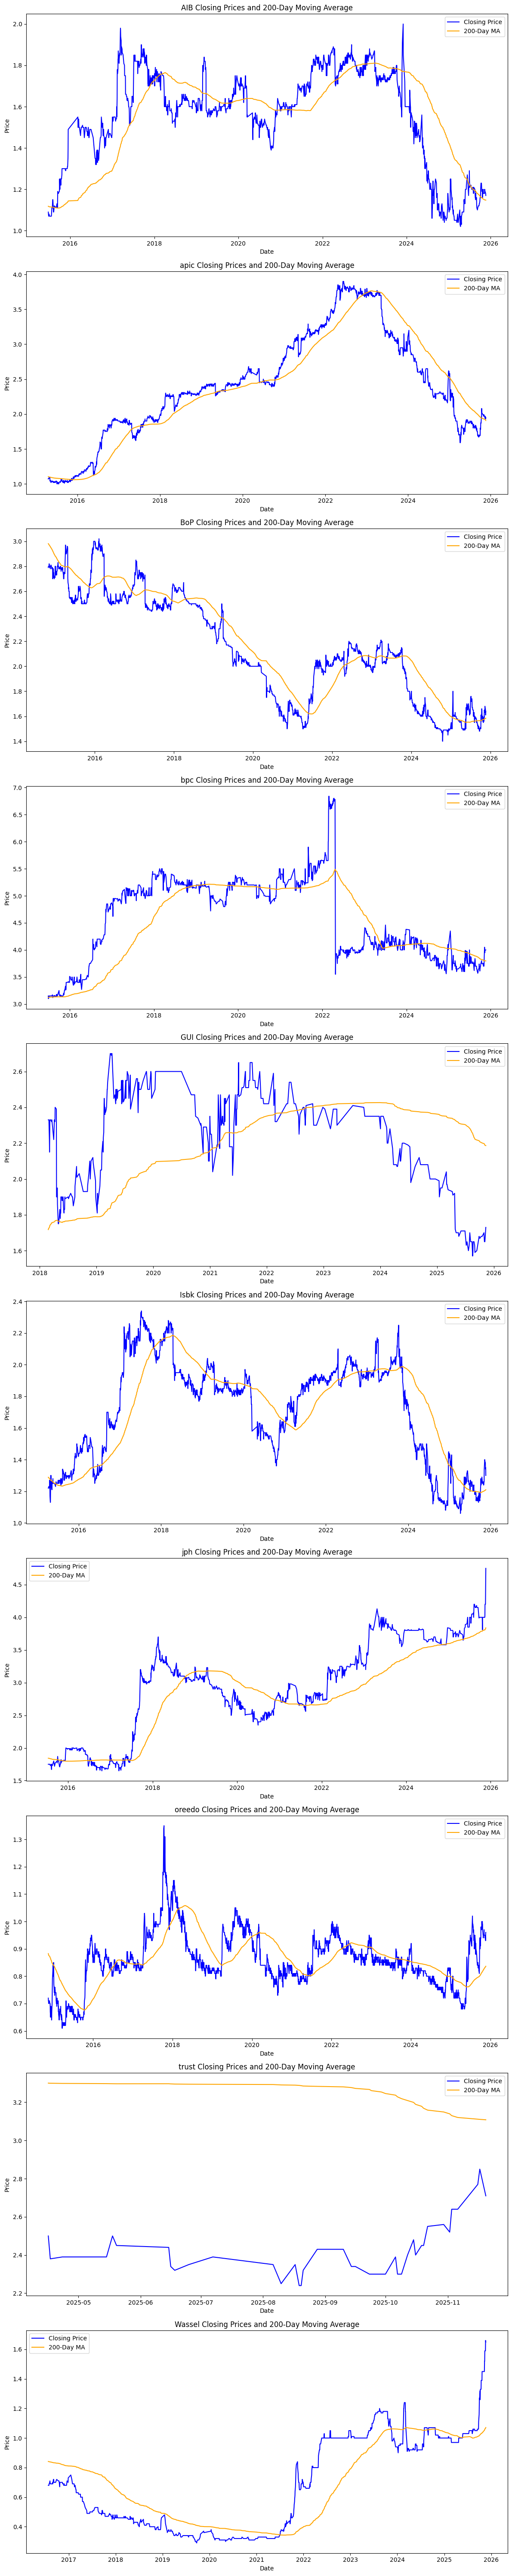

In [19]:
import visualize
importlib.reload(visualize)
from visualize import plot_stocks_closing_200MA
plot_stocks_closing_200MA(df)

`Working with individual stocks`

In [20]:
importlib.reload(utils)
from utils import take_stock

            highest  lowest  closing  opening   volume      value  n_deals  \
date                                                                         
2014-01-02     3.20    3.19     3.20     3.19  25566.0   81800.50       19   
2014-01-05     3.17    3.12     3.19     3.13  24331.0   76502.03       28   
2014-01-06     3.15    3.12     3.13     3.13  94225.0  295711.69       31   
2014-01-08     3.17    3.13     3.13     3.17  44673.0  141304.63       19   
2014-01-09     3.19    3.17     3.17     3.19  29244.0   93072.42       32   

            change_pctg  
date                     
2014-01-02     0.313480  
2014-01-05     1.916933  
2014-01-06     0.000000  
2014-01-08    -1.261830  
2014-01-09    -0.626959  


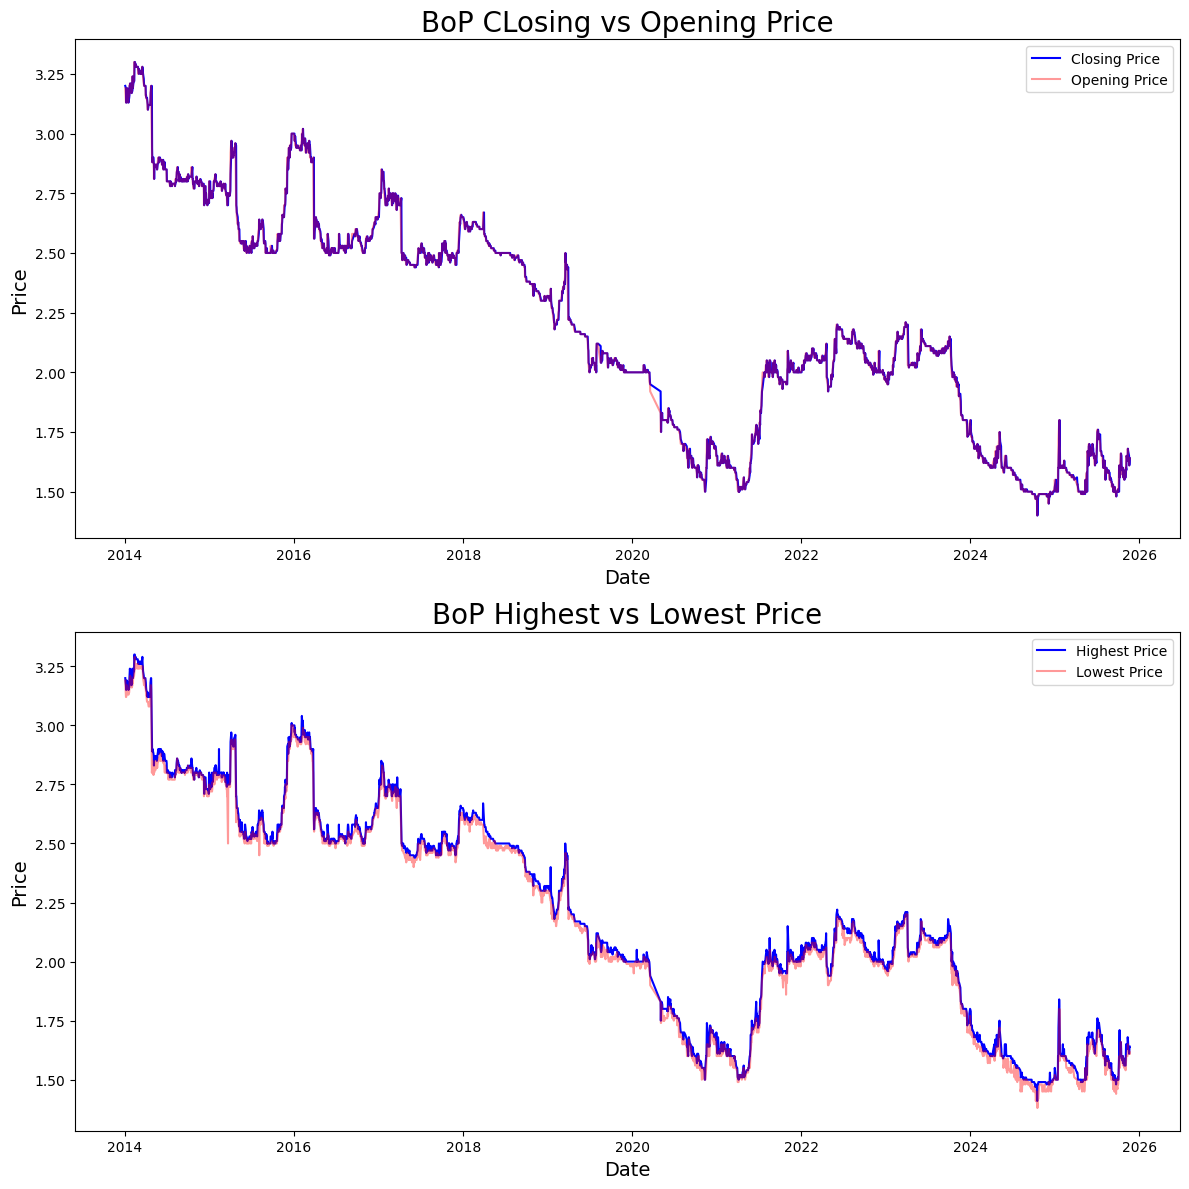

In [21]:
bop = take_stock(df, 'BoP')

`As we can see from the first graph we cacn tell that opening and closing prices are almost always identical indicating the low volatility in PEX in general`

----------------------------------

`The initial model we will try is to predict the direction of the movement for stock`

## 1.2 `Creating informative variables`

`First of all create the movemetn direction target variable`

`Create 1 Day Classification target variable with concern for predicting up movements`

### 1.2.1 `Create The Target Variable`

In [22]:
importlib.reload(utils)
from utils import create_and_plot as cp

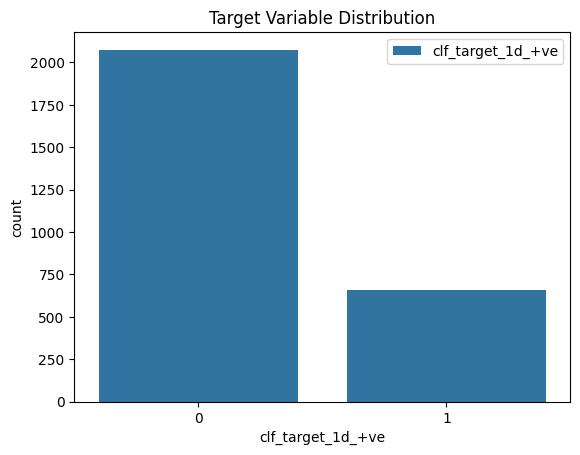

KeyError: 'c'

In [23]:
bop = cp(bop, "target")

### 1.2.2 `Create Time Since Last Trade Variable`

In [ ]:
importlib.reload(utils)
from utils import create_and_plot as cp

In [ ]:
bop = cp(bop, "time_since_last")

### 1.2.3 `Create Moving Averages`

In [ ]:
importlib.reload(utils)
from utils import create_and_plot as cp

Moving Average for 20 Days Created.
Moving Average for 50 Days Created.
Moving Average for 200 Days Created.
MA Ratio Created


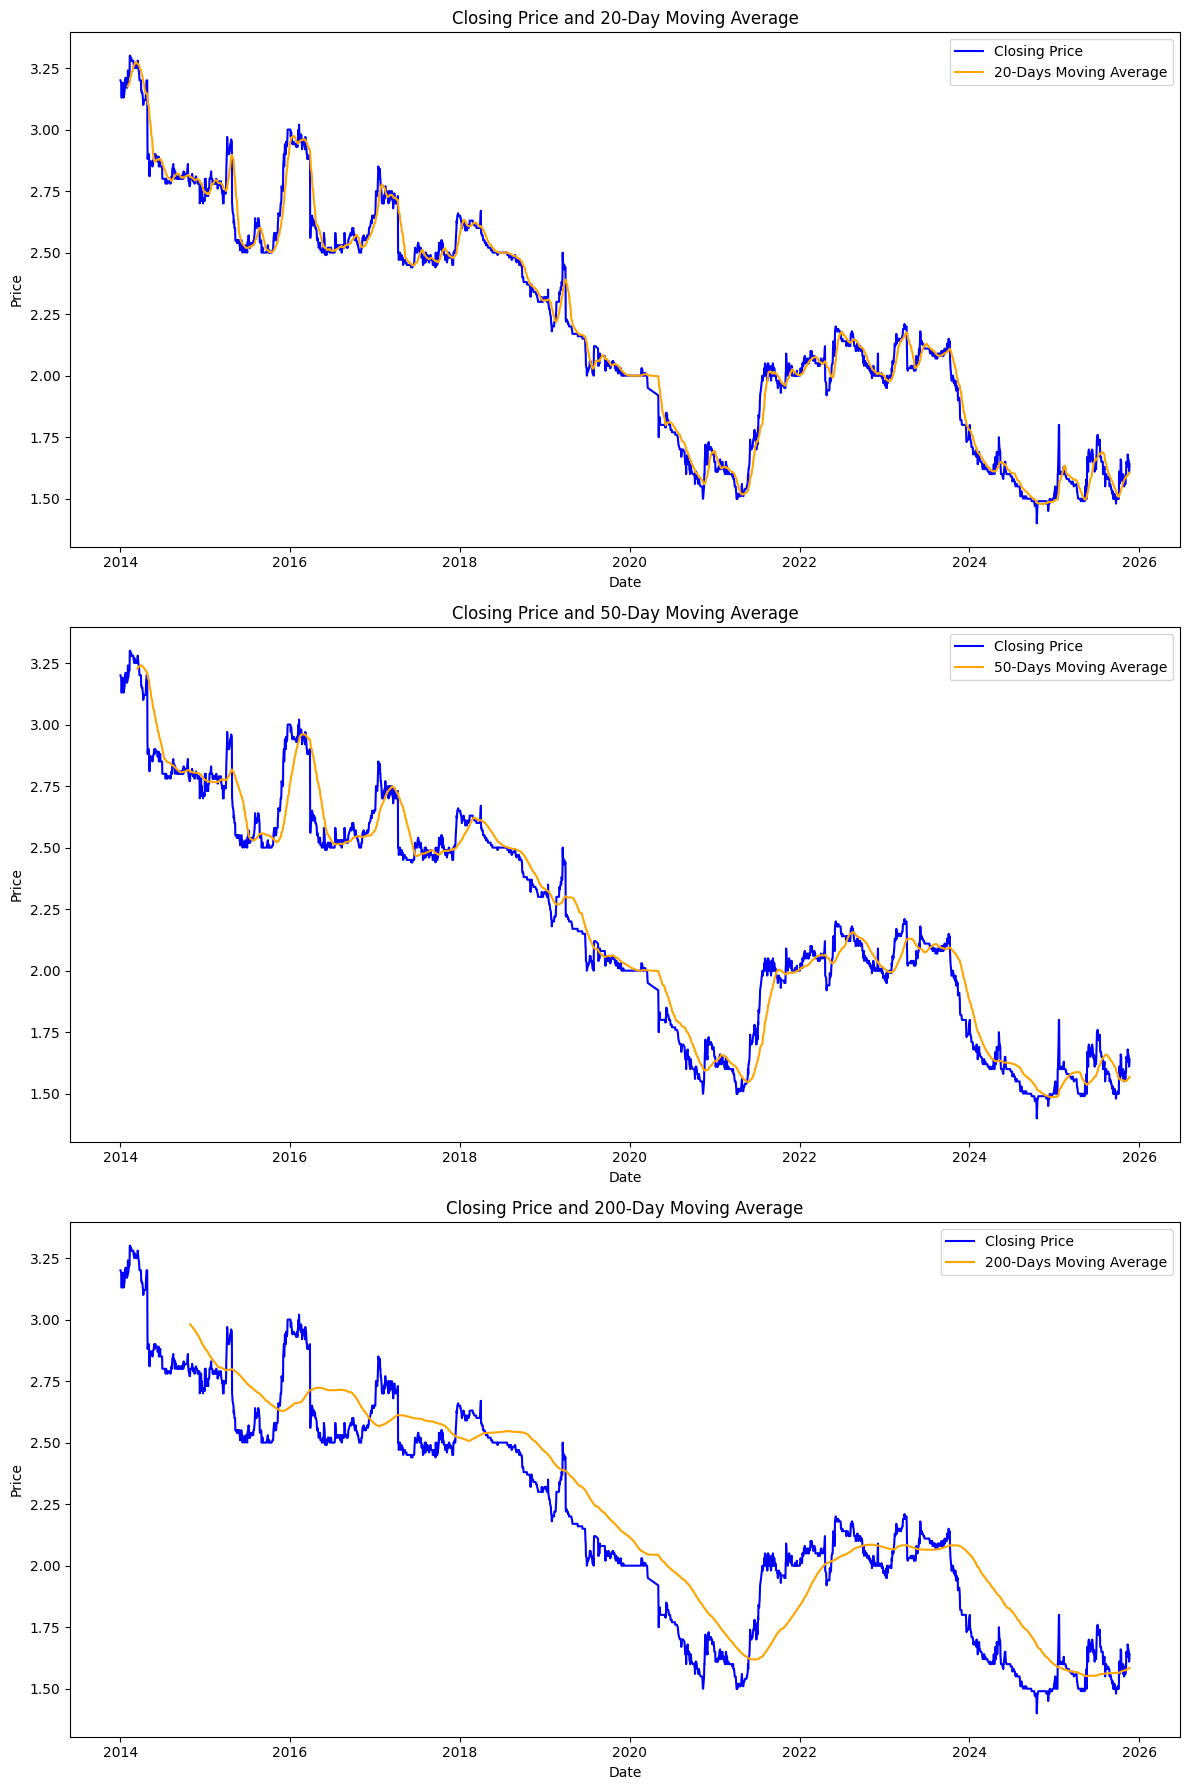

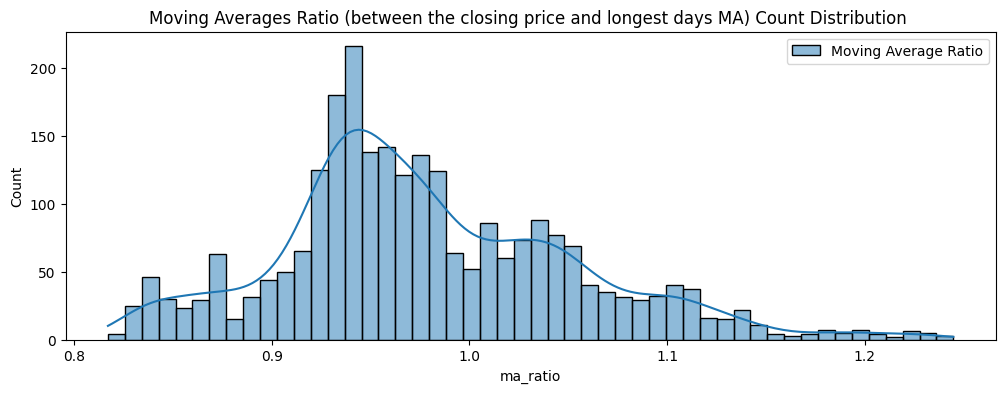

           20_MA     50_MA    200_MA
20_MA   1.000000  0.992929  0.941401
50_MA   0.992929  1.000000  0.958691
200_MA  0.941401  0.958691  1.000000
Variables with Strong Correlation (> 0.25) :  [('highest', 0.9919847331585684), ('lowest', 0.9919540797355673), ('closing', 0.9932821524335053), ('opening', 0.9921796515304773), ('n_deals', 0.2773843524541212)]


In [24]:
bop = cp(bop, "moving_averages")

`This chart makes total sense since PEX ahs very low volatility which is why even the 20MA almost perfectly hugs the closign price`

`MA won't reveal much information and alone is not enough for ML model to revela hideen patterns we need to create more features`

### 1.2.4 `Create Range Variable`

In [29]:
importlib.reload(utils)
from utils import create_and_plot as cp

Variables with Strong Correlation (> 0.25) :  [('n_deals', 0.3969986927888677)]


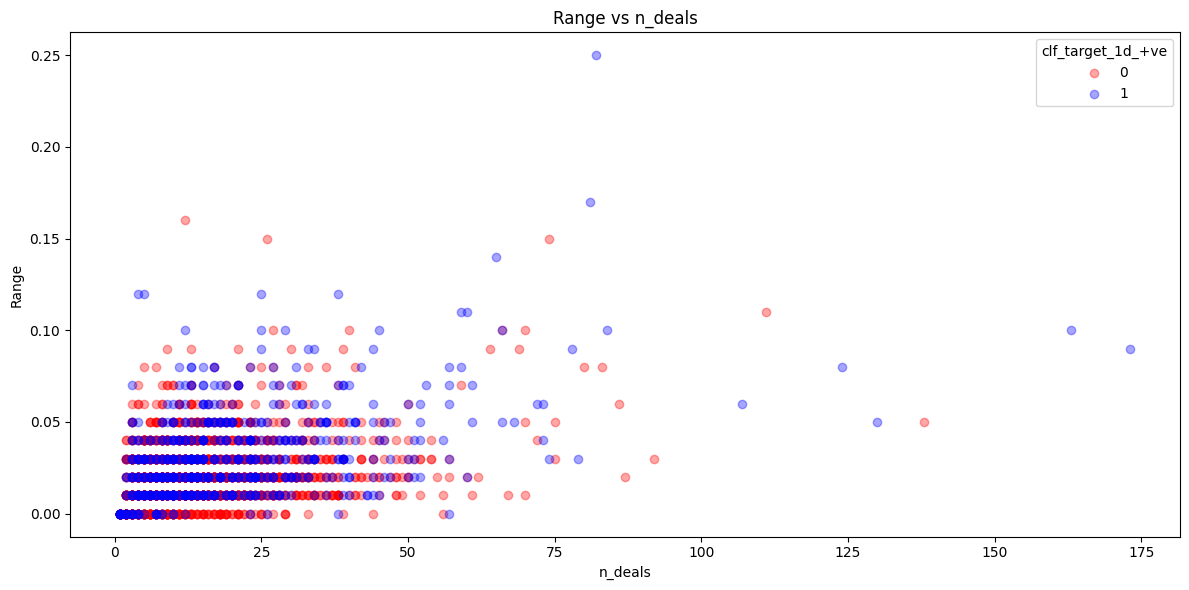

In [30]:
bop = cp(bop, "target", plot=False, corr=True)
bop = cp(bop, "range")

### 1.2.5 `Crate Daily Returns Variables`

1-Day Return Variable Created.
3-Day Return Variable Created.
5-Day Return Variable Created.


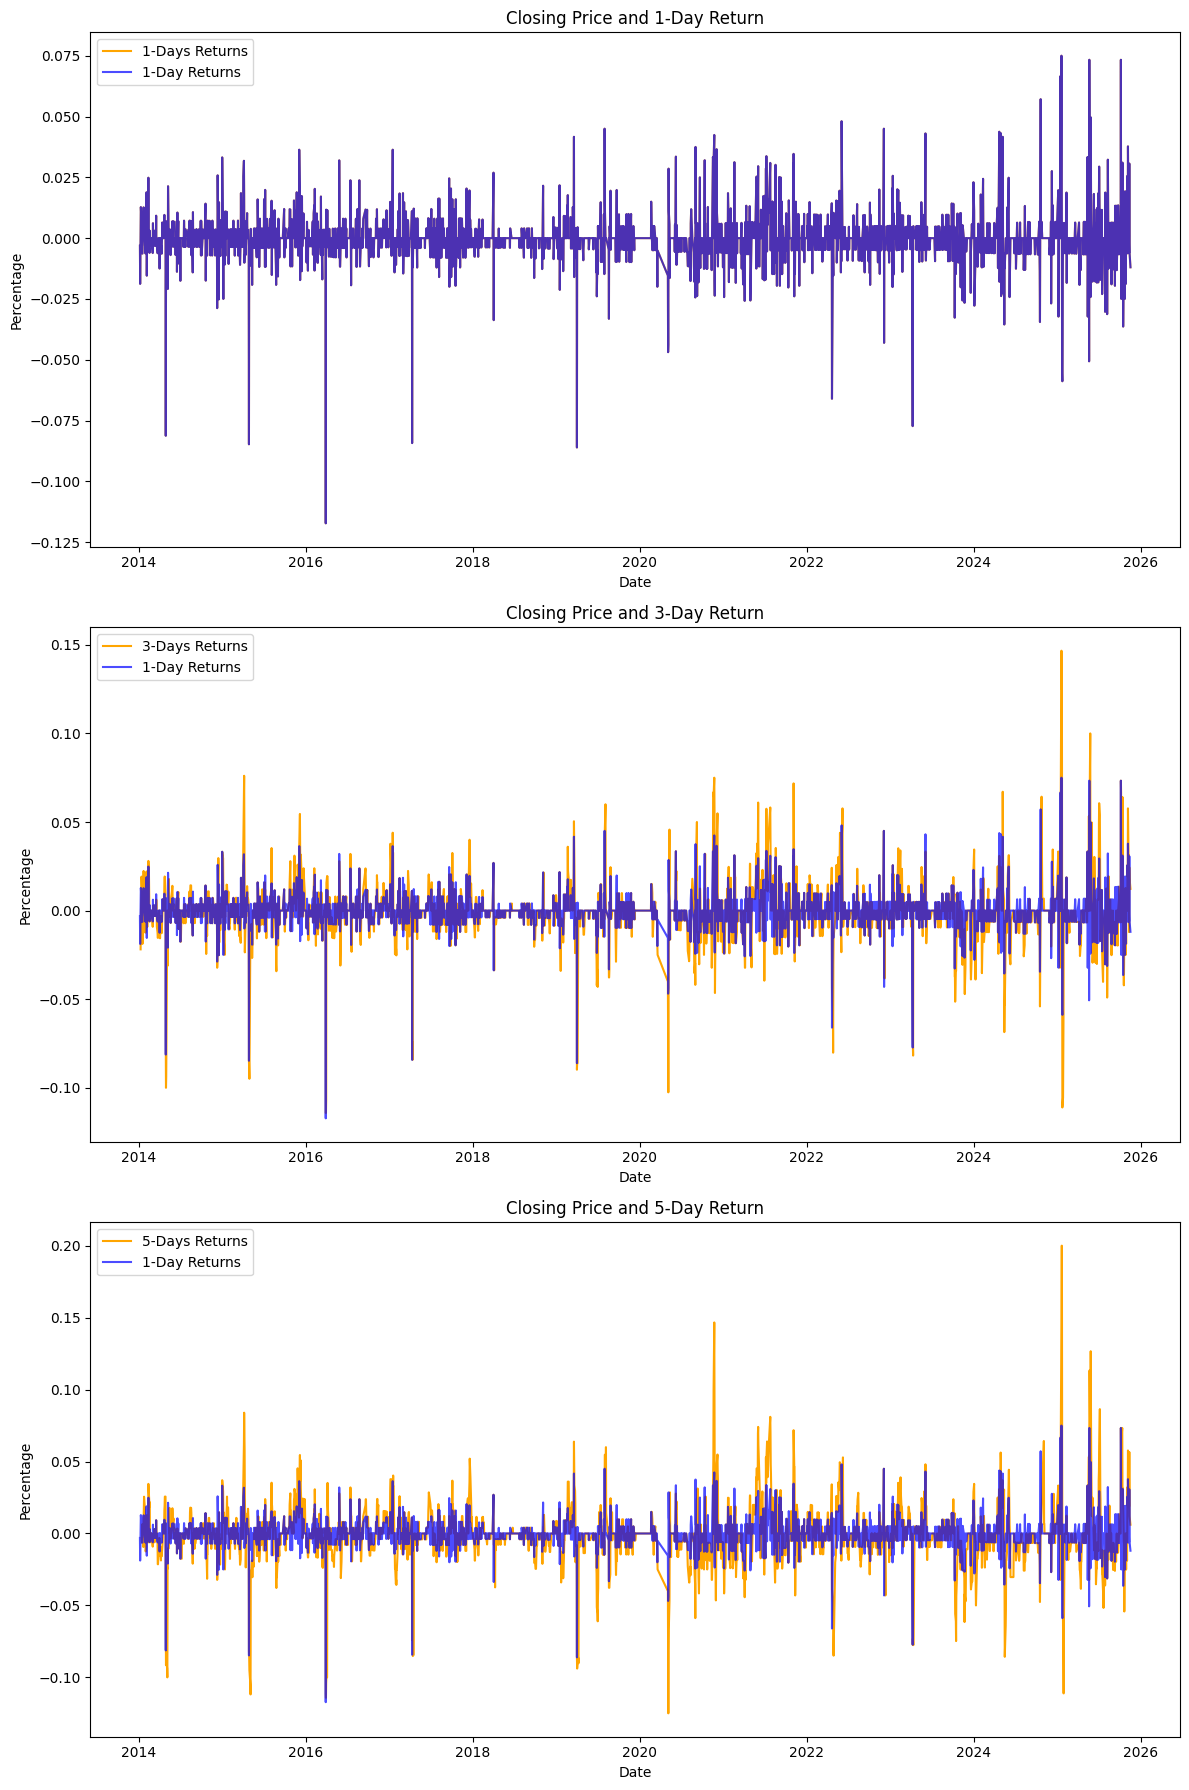

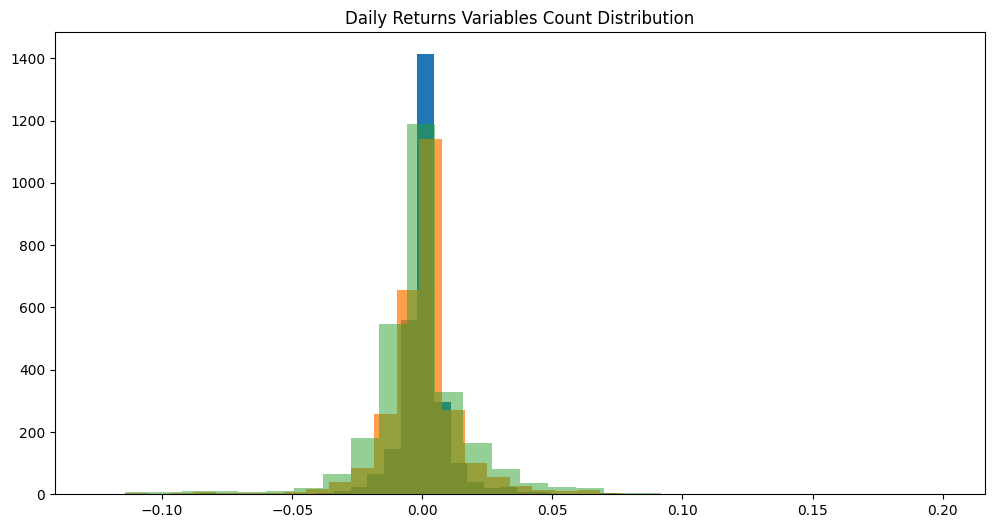

          r1        r3        r5
r1  1.000000  0.561597  0.443251
r3  0.561597  1.000000  0.762175
r5  0.443251  0.762175  1.000000
No Strong Pearson Correlations.


In [31]:
bop = cp(bop, "returns")

`As we can see the returns distibution has fatter tails on the longer run which makes total sense for a low volatility market`

### 1.2.6 `volatility X days`

10-Day Volatility Variable Created.
20-Day Volatility Variable Created.
30-Day Volatility Variable Created.


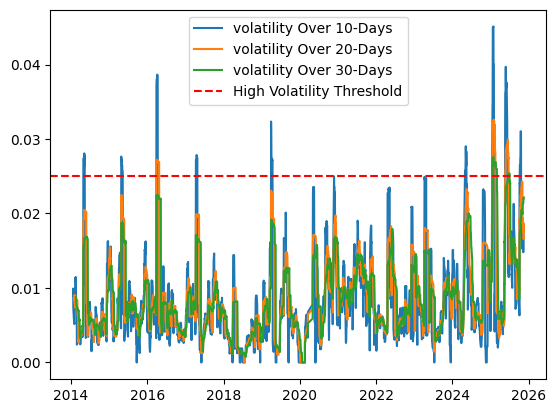

                volatility_10d  volatility_20d  volatility_30d
volatility_10d        1.000000        0.762195        0.640781
volatility_20d        0.762195        1.000000        0.855231
volatility_30d        0.640781        0.855231        1.000000
Variables with Strong Correlation (> 0.25) :  [('200_MA', -0.26791092289973617)]


In [32]:
bop = cp(bop, "volatility")

`For reference comparing BoP with oreedo who is riskier`

In [33]:
from utils import take_stock

In [34]:
ord = take_stock(df, 'oreedo', plot=False)

In [35]:
importlib.reload(utils)
from utils import create_and_plot as cp

10-Day Volatility Variable Created.
20-Day Volatility Variable Created.
30-Day Volatility Variable Created.


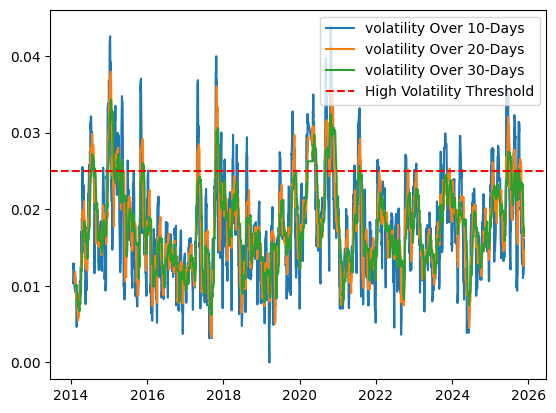

                volatility_10d  volatility_20d  volatility_30d
volatility_10d        1.000000        0.807378        0.678189
volatility_20d        0.807378        1.000000        0.887623
volatility_30d        0.678189        0.887623        1.000000


In [36]:
ord = cp(ord, "returns", plot=False, corr=False)
ord = cp(ord, "volatility", corr=False)

### 1.1.5 RSI

In [40]:
import utils
importlib.reload(utils)
from utils import create_and_plot as cp

RSI for 7- days created.
RSI for 14- days created.
RSI for 21- days created.


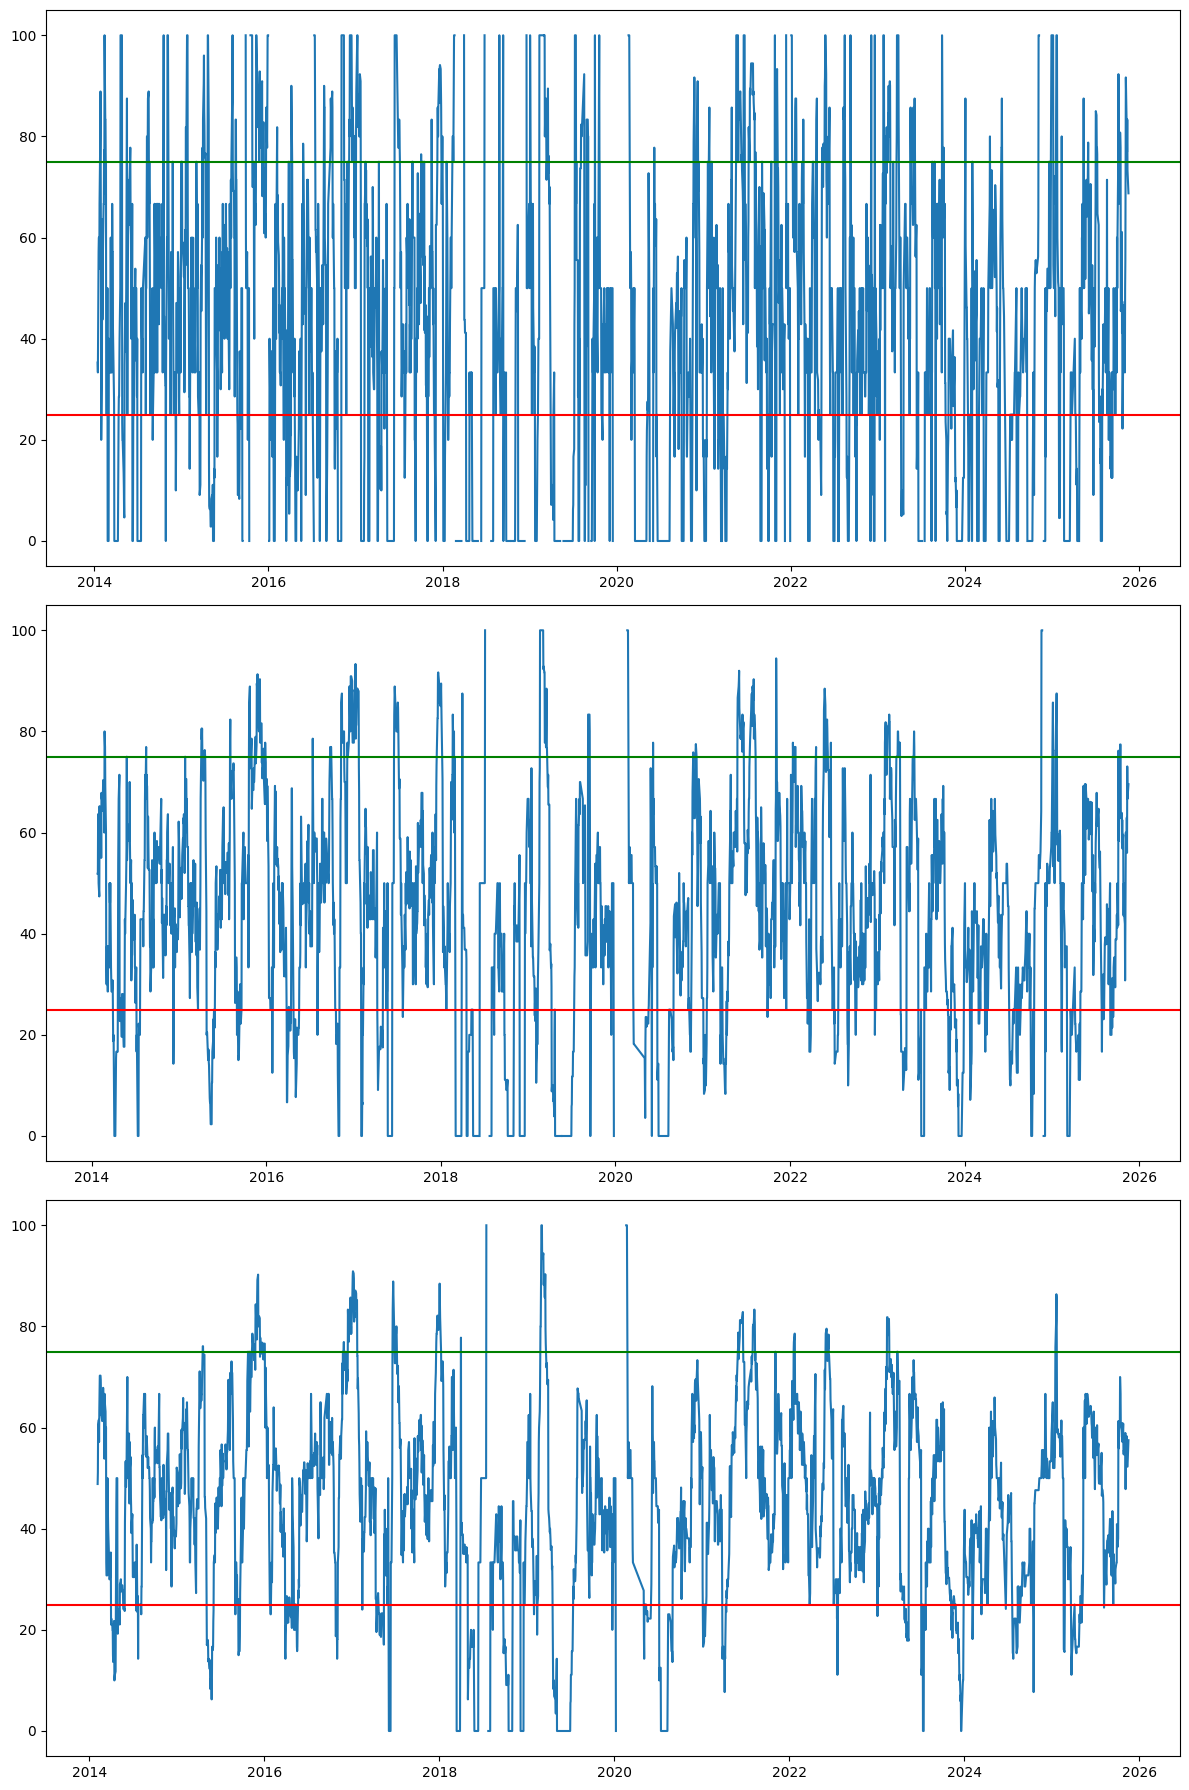

           rsi_7    rsi_14    rsi_21
rsi_7   1.000000  0.721387  0.600733
rsi_14  0.721387  1.000000  0.831596
rsi_21  0.600733  0.831596  1.000000
Variables with Strong Correlation with variable rsi_7 (> 0.25) :  [('ma_ratio', 0.2886232354435127), ('r1', 0.2951647986754177), ('r3', 0.4660990431609052), ('r5', 0.5799286853738692)]


In [41]:
bop = cp(bop, "rsi", plot=True)

### 1.1.6 Liquidity features

In [52]:
importlib.reload(utils)
from utils import create_and_plot as cp

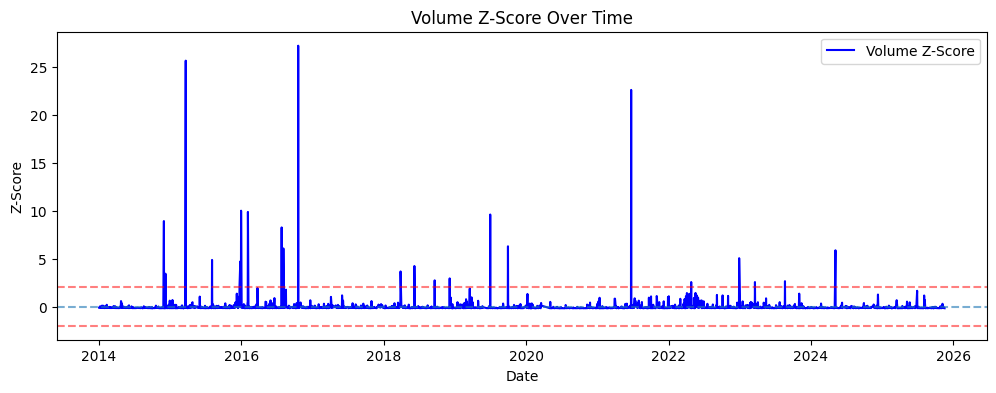

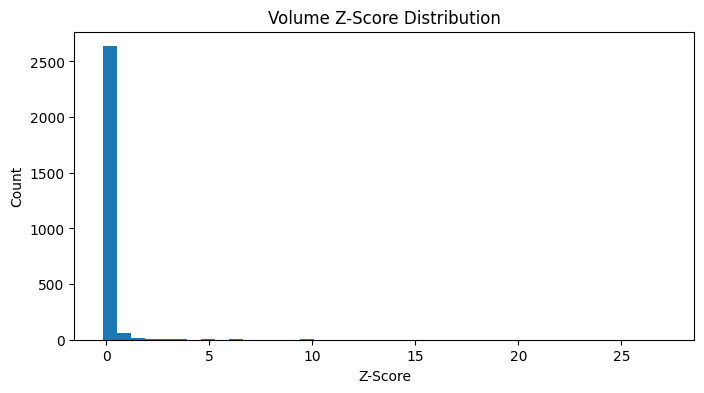

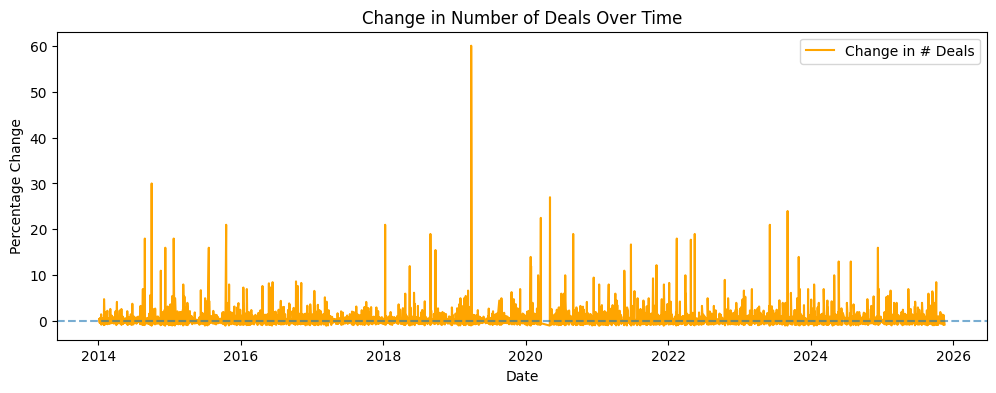

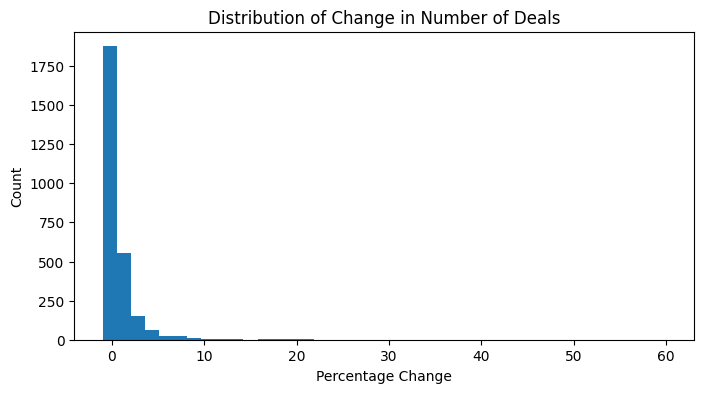

In [53]:
bop = cp(bop, "liquidity")

---------------------------------------

In [ ]:
bop['range_norm'] = bop['range'] / bop['closing']

In [ ]:
bop[['range', 'range_norm']].corr()

In [ ]:
bop.drop(columns='range', inplace=True)

In [ ]:
bop['day_of_week'] = bop.index.dayofweek

In [ ]:
bop['first_5d_of_month'] = (bop.index.day <= 5).astype(int)

In [ ]:
bop['ema12'] = bop['closing'].ewm(span=12, adjust=False).mean()
bop['ema26'] = bop['closing'].ewm(span=26, adjust=False).mean()

bop['macd'] = bop['ema12'] - bop['ema26']
bop['macd_signal'] = bop['macd'].ewm(span=9, adjust=False).mean()
bop['macd_hist'] = bop['macd'] - bop['macd_signal']

In [ ]:
bop.drop(columns=['ema12', 'ema26', 'macd_signal'], inplace=True)

In [ ]:
window = 14
low14 = bop['lowest'].rolling(window).min()
high14 = bop['highest'].rolling(window).max()

bop['stoch_k'] = 100 * ((bop['closing'] - low14) / (high14 - low14))
bop['stoch_d'] = bop['stoch_k'].rolling(3).mean()


In [ ]:
bop.drop(columns=['opening', 'highest', 'lowest'], inplace=True)

In [ ]:
bop.drop(columns=['time_since_last'], inplace=True)

In [ ]:
bop.columns

`Checking possible multi colinearity reasons`

```python
bop[['volume', 'value']].corr()
##
ord = df.loc['oreedo', : ].copy()
ord[['volume', 'value']].corr()
```

`Since we have almost perfect correlation between (volume X value) we can drop the value column `

```python
df.drop(columns=['value'], inplace=True)
ord.drop(columns=['value'], inplace=True)
bop.drop(columns=['value'], inplace=True)
```

-----------------------------------------------------------------------

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    roc_auc_score, average_precision_score, confusion_matrix
)
from sklearn.inspection import permutation_importance
import joblib

In [ ]:
df = bop.copy()


In [ ]:
all_cols = ['closing', 'change_pctg', 'n_deals',  '20_day_MA',
        '200_day_MA', '50_day_MA', 'ma_ratio', 'r1', 'r3', 'r5',
        'volatility_10d', 'volatility_20d', 'rsi_14', 'rsi_7', 'rsi_21',
        'volume_z', 'n_deals_change', 'range_norm', 'day_of_week',
        'first_5d_of_month', 'macd', 'macd_hist', 'stoch_k', 'stoch_d']

target_col = 'target'
feature_cols = [c for c in all_cols if c != target_col]

In [ ]:
for c in feature_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')
df[target_col] = (df[target_col].astype(int)
                  if df[target_col].dropna().isin([0,1]).all()
                  else df[target_col])

In [ ]:
df = df.dropna(subset=[target_col]).reset_index(drop=True)

X = df[feature_cols]
y_long = df[target_col].values
y_short = np.abs(y_long - 1)

In [ ]:
y = y_short

In [ ]:
n = len(df)
test_size = max( int(0.2 * n), 100 )  
split_idx = n - test_size

X_trainval, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_trainval, y_test = y[:split_idx], y[split_idx:]

In [ ]:
n

In [ ]:
cat_cols = ['day_of_week']                 # one-hot (weekday effect)
bin_cols = ['first_5d_of_month']           # keep as numeric (0/1)
num_cols = [c for c in feature_cols if c not in cat_cols + bin_cols]

In [ ]:
sk = df[num_cols].skew()
mean_cols = [c for c in num_cols if abs(sk[c]) < 0.5]
median_cols = [c for c in num_cols if abs(sk[c]) >= 0.5]

In [ ]:
median_pre = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

In [ ]:
mean_pre = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),    
    ('scaler', StandardScaler())
])

In [ ]:
binary_pre = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

In [ ]:
categorical_pre = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('oh', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

In [ ]:
preprocess = ColumnTransformer(transformers=[
    ('mean', mean_pre, mean_cols),
    ('median', median_pre, median_cols),
    ('bin', binary_pre, bin_cols),
    ('cat', categorical_pre, cat_cols)
], remainder='drop')

In [ ]:
lr_clf = Pipeline(steps=[
    ('prep', preprocess),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', n_jobs=None))
])


gb_clf = Pipeline(steps=[
    ('prep', preprocess),
    ('clf', GradientBoostingClassifier(random_state=42))
])

candidates = {
    'LogisticRegression': lr_clf,
    'GradientBoosting': gb_clf
}


In [ ]:
tscv = TimeSeriesSplit(n_splits=5)
cv_scores = {}

In [ ]:
def pr_auc(y_true, y_proba):
    # average_precision_score is PR-AUC
    return average_precision_score(y_true, y_proba)

In [ ]:
fold_scores = {'precision':[], 'recall':[], 'f1':[], 'pr_auc':[]}
for tr_idx, va_idx in tscv.split(X_trainval):
    X_tr, X_va = X_trainval.iloc[tr_idx], X_trainval.iloc[va_idx]
    y_tr, y_va = y_trainval[tr_idx], y_trainval[va_idx]
    lr_clf.fit(X_tr, y_tr)
    # Some sklearn classifiers expose predict_proba; others only decision_function
    proba = lr_clf.predict_proba(X_va)[:, 1]
    fold_scores['pr_auc'].append(pr_auc(y_va, proba))
    fold_scores['precision'].append(precision_recall_fscore_support(y_va, lr_clf.predict(X_va), average='binary')[0])
    fold_scores['recall'].append(precision_recall_fscore_support(y_va, lr_clf.predict(X_va), average='binary')[1])
    fold_scores['f1'].append(precision_recall_fscore_support(y_va, lr_clf.predict(X_va), average='binary')[2])
cv_mean_pre = np.mean(fold_scores['precision'])
cv_mean_rec = np.mean(fold_scores['recall'])
cv_mean_f1 = np.mean(fold_scores['f1'])
cv_mean = np.mean(fold_scores['pr_auc'])
#cv_std  = np.std(fold_scores)

In [ ]:
fold_scores

In [ ]:
lr_clf.fit(X_trainval, y_trainval)

In [ ]:
test_proba = lr_clf.predict_proba(X_test)[:, 1]


In [ ]:
test_pred = (test_proba >= 0.5).astype(int)

In [ ]:
acc = accuracy_score(y_test, test_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, test_pred, average='binary', zero_division=0)
roc = roc_auc_score(y_test, test_proba)
prauc = average_precision_score(y_test, test_proba)
cm = confusion_matrix(y_test, test_pred)

In [ ]:
print("\n=== Test Metrics ===")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1: {f1:.4f}")
print(f"ROC-AUC: {roc:.4f}")
print(f"PR-AUC: {prauc:.4f}")
print("Confusion Matrix:\n", cm)

In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    roc_auc_score, average_precision_score
)
import numpy as np
import pandas as pd
import torch
import torch.nn as nn


# -------------------------------------------------------
# Helper: get probabilities for models without predict_proba
# -------------------------------------------------------
def get_proba(model, X):
    if hasattr(model, "predict_proba"):
        return model.predict_proba(X)[:, 1]
    elif hasattr(model, "decision_function"):
        scores = model.decision_function(X)
        return 1 / (1 + np.exp(-scores))       # logistic transform
    else:
        preds = model.predict(X)
        return preds.astype(float)


# -------------------------------------------------------
# Evaluate a model
# -------------------------------------------------------
def evaluate(model, X_test, y_test, name="Model"):
    proba = get_proba(model, X_test)
    pred = (proba >= 0.5).astype(int)

    acc = accuracy_score(y_test, pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_test, pred, average='binary', zero_division=0
    )
    roc = roc_auc_score(y_test, proba)
    prauc = average_precision_score(y_test, proba)

    print(f"\n=== {name} ===")
    print(f"Accuracy:   {acc:.4f}")
    print(f"Precision:  {prec:.4f}")
    print(f"Recall:     {rec:.4f}")
    print(f"F1-score:   {f1:.4f}")
    print(f"ROC-AUC:    {roc:.4f}")
    print(f"PR-AUC:     {prauc:.4f}")

    return {
        "name": name,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "roc_auc": roc,
        "pr_auc": prauc
    }




# -------------------------------------------------------
# MAIN FUNCTION: Train all models and evaluate
# -------------------------------------------------------
def compare_models(X_train, y_train, X_test, y_test):

    # Models
    models = {
        #"SVC Linear": SVC(kernel='linear', probability=True),
        #"SVC RBF": SVC(kernel='rbf', probability=True, gamma='scale'),
        #"SVC Poly": SVC(kernel='poly', degree=3, probability=True),
        "Random Forest": RandomForestClassifier(n_estimators=300, class_weight='balanced', random_state=42),
        "XGBoost": XGBClassifier(
            n_estimators=300,
            max_depth=5,
            learning_rate=0.05,
            subsample=0.9,
            eval_metric='logloss',
            class_weight='balanced',
            random_state=42
        )
    }

    results = []

    for name, model in models.items():
        model.fit(X_train, y_train)
        res = evaluate(model, X_test, y_test, name)
        results.append(res)

    print("\nTraining LSTM (optional)...")
    train_lstm(X_train, y_train, X_test, y_test)

    return results


In [ ]:
pd.DataFrame(y_test).value_counts()

In [ ]:
print(fold_scores['precision'][-1])
print(fold_scores['recall'][-1])
print(fold_scores['f1'][-1])

In [ ]:
compare_models(X_trainval, y_trainval, X_test, y_test)


In [ ]:
df.index

In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    roc_auc_score, average_precision_score
)
import numpy as np
import pandas as pd
import torch
import torch.nn as nn


# -------------------------------------------------------
# Helper: get probabilities for models without predict_proba
# -------------------------------------------------------
def get_proba(model, X):
    if hasattr(model, "predict_proba"):
        return model.predict_proba(X)[:, 1]
    elif hasattr(model, "decision_function"):
        scores = model.decision_function(X)
        return 1 / (1 + np.exp(-scores))       # logistic transform
    else:
        preds = model.predict(X)
        return preds.astype(float)


# -------------------------------------------------------
# Evaluate a model
# -------------------------------------------------------
def evaluate(model, X_test, y_test, name="Model"):
    proba = get_proba(model, X_test)
    pred = (proba >= 0.5).astype(int)

    acc = accuracy_score(y_test, pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_test, pred, average='binary', zero_division=0
    )
    roc = roc_auc_score(y_test, proba)
    prauc = average_precision_score(y_test, proba)

    print(f"\n=== {name} ===")
    print(f"Accuracy:   {acc:.4f}")
    print(f"Precision:  {prec:.4f}")
    print(f"Recall:     {rec:.4f}")
    print(f"F1-score:   {f1:.4f}")
    print(f"ROC-AUC:    {roc:.4f}")
    print(f"PR-AUC:     {prauc:.4f}")

    return {
        "name": name,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "roc_auc": roc,
        "pr_auc": prauc
    }




# -------------------------------------------------------
# MAIN FUNCTION: Train all models and evaluate
# -------------------------------------------------------
def compare_models(X_train, y_train, X_test, y_test):

    # Models
    models = {
        #"SVC Linear": SVC(kernel='linear', probability=True),
        #"SVC RBF": SVC(kernel='rbf', probability=True, gamma='scale'),
        #"SVC Poly": SVC(kernel='poly', degree=3, probability=True),
        "Random Forest": RandomForestClassifier(n_estimators=300, class_weight='balanced', random_state=42),
        "XGBoost": XGBClassifier(
            n_estimators=300,
            max_depth=5,
            learning_rate=0.05,
            subsample=0.9,
            eval_metric='logloss',
            class_weight='balanced',
            random_state=42
        )
    }

    results = []

    for name, model in models.items():
        model.fit(X_train, y_train)
        res = evaluate(model, X_test, y_test, name)
        results.append(res)

    print("\nTraining LSTM (optional)...")
    train_lstm(X_train, y_train, X_test, y_test)

    return results
